# Overview
- Get and explore images
- Prepare data for the model
- Basic CNN model
- Transfer Learning
  - Prepare data
  - Create a feature extractor model (VGG16)
  - Setting up mixed precision for faster training 
  - Load and evaluate checkpoint weights
  - Setup early stoping, checkpoint, learning rate reduction callbacks
  - Fine tune feature extraction model (VGG16)
  - Make prediction using our final trained model

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential

In [ ]:
print(tf.__version__)

2.5.0


# Explore data

In [ ]:
import os
# Walk through pizza_steak directory and list number of files
print("Train data: ")
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files/image_intel/seg_train/seg_train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Test data: ")
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files/image_intel/seg_test/seg_test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
print("Prediction data: ")
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Files/image_intel/seg_pred/seg_pred"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Train data: 
There are 6 directories and 0 images in '/content/drive/MyDrive/Files/image_intel/seg_train/seg_train'.
There are 0 directories and 2191 images in '/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/buildings'.
There are 0 directories and 2271 images in '/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/forest'.
There are 0 directories and 2512 images in '/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/mountain'.
There are 0 directories and 2404 images in '/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/glacier'.
There are 0 directories and 2382 images in '/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/street'.
There are 0 directories and 2274 images in '/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/sea'.
Test data: 
There are 6 directories and 0 images in '/content/drive/MyDrive/Files/image_intel/seg_test/seg_test'.
There are 0 directories and 474 images in '/content/drive/MyDrive/Files/image_inte

In [ ]:
import random
import matplotlib.pyplot as plt
def view_random_image(target_dir, target_class):
  # We will view image from here
  target_folder = target_dir + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder+'/'+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off');
  print(f"Image shape {img.shape}")

  return img

Image shape (150, 150, 3)


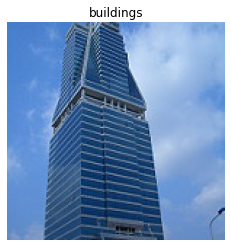

In [ ]:
img = view_random_image(target_dir='/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/',
                  target_class='buildings')

In [ ]:
# Get the class name programmatically
import pathlib
data_dir = pathlib.Path("/content/drive/MyDrive/Files/image_intel/seg_train/seg_train")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)
Image shape (150, 150, 3)


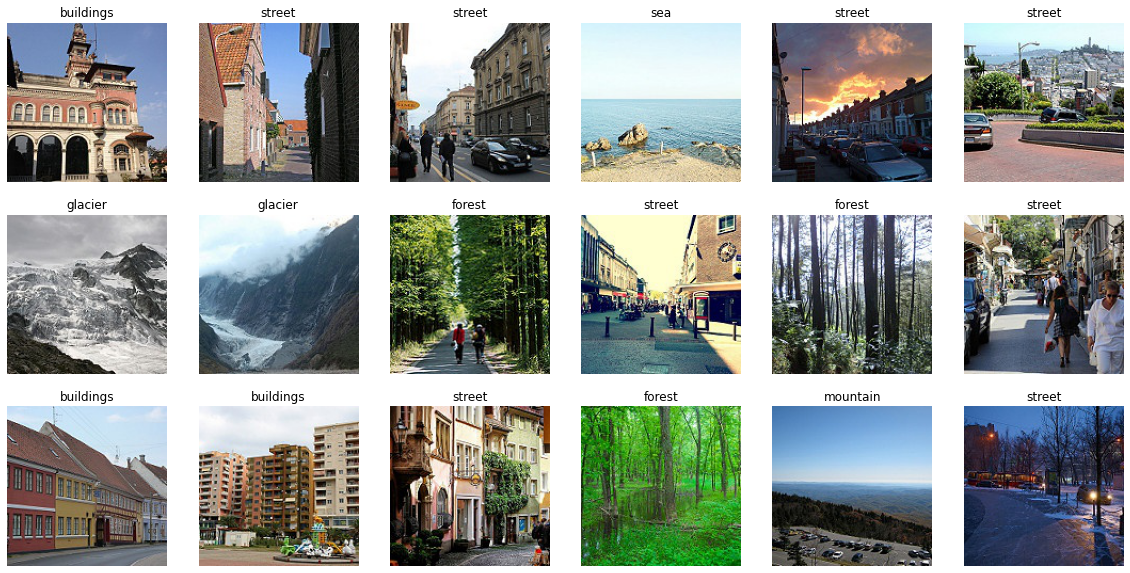

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(18):
  plt.subplot(3, 6, i+1)
  class_name = random.choice(class_names)
  img = view_random_image(target_dir='/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/',
                  target_class=class_name)

# Prepare data for model

In [ ]:
train_dir = "/content/drive/MyDrive/Files/image_intel/seg_train/seg_train/"
test_dir = "/content/drive/MyDrive/Files/image_intel/seg_test/seg_test/"

In [ ]:
# Create augmented data generator instance
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1/255.)

# Load data(data, label) from directory and turn them into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(150,150),
                                               batch_size=32,
                                               class_mode='categorical')
test_data = val_datagen.flow_from_directory(test_dir,
                                           target_size=(150,150),
                                           batch_size=32,
                                           class_mode='categorical')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Basic model Buildinig (CNN Classifier)

In [ ]:
model_1 = Sequential([
  Conv2D(16, 3, padding='same', activation='relu', input_shape=(150,150,3)),
  MaxPool2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(len(class_names), activation='softmax')
])

model_1.compile(loss="categorical_crossentropy",
              optimizer=Adam(),
              metrics=['accuracy'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [ ]:
history_1 = model_1.fit(train_data,
                    epochs=4,
                    batch_size=32,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data))

Epoch 1/4
  7/439 [..............................] - ETA: 1:34:44 - loss: 2.0631 - accuracy: 0.1964

KeyboardInterrupt: ignored

In [ ]:
model_1.evaluate(test_data)

In [ ]:
pd.DataFrame(history_1.history)[['loss','val_loss']].plot()
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss');

In [ ]:
pd.DataFrame(history_1.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy');

In [ ]:
model.save('./models', save_format='tf')

In [ ]:
!ls -alrt models

In [ ]:
model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/Files/image_intel/models/models/')

In [ ]:
model_loaded.summary()

In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def process(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')
   np_image = transform.resize(np_image, (150, 150, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

In [ ]:
pred_label=model_loaded.predict(process('/content/drive/MyDrive/Files/image_intel/alto-crew-Rv3ecImL4ak-unsplash.jpg'))
print(classes[np.argmax(pred_label)])

In [ ]:
pred_label

In [ ]:
!zip -r models.zip models/